<a href="https://colab.research.google.com/github/ytg000629/Dacon_Dobae/blob/main/Inception-ResNet-V2_%EC%8B%A4%ED%8C%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import package
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import time
import copy

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
all_img_list = glob.glob('/content/drive/MyDrive/dacon/data/train/*/*')

In [5]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[-2])

In [6]:
df.head(20)

,img_path,label
0,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
1,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
2,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
3,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
4,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
5,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
6,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
7,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
8,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정
9,/content/drive/MyDrive/dacon/data/train/가구수...,가구수정


In [7]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [9]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])
#shuffle = True가 디폴트
#shuffle 안되어있으면 순서까지 학습할 수 있어서 shuffle 필수

In [53]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [62]:
train.head()

,img_path,label
3322,/content/drive/MyDrive/dacon/data/train/훼손/...,18
2089,/content/drive/MyDrive/dacon/data/train/훼손/...,18
2321,/content/drive/MyDrive/dacon/data/train/훼손/...,18
2599,/content/drive/MyDrive/dacon/data/train/훼손/...,18
2305,/content/drive/MyDrive/dacon/data/train/훼손/...,18


In [10]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [63]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [64]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_dl = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_dl = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

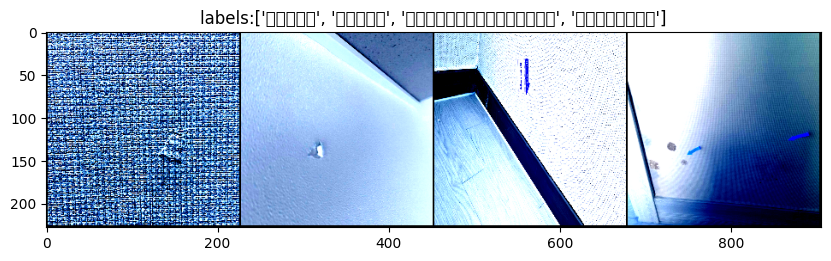

In [13]:
def show(img, y=None, color=True): 
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(0)
torch.manual_seed(0)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_dataset), grid_size)

x_grid = [train_dataset[i][0] for i in rnd_ind]
y_grid = [train_dataset[i][1] for i in rnd_ind]

plt.figure(figsize=(10,10))
x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
show(x_grid, y_grid)

In [14]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        # bias=Fasle, because BN after conv includes bias.
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [75]:
class Stem(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            BasicConv2d(3, 32, 3, stride=2, padding=0), # 149 x 149 x 32
            BasicConv2d(32, 32, 3, stride=1, padding=0), # 147 x 147 x 32
            BasicConv2d(32, 64, 3, stride=1, padding=1), # 147 x 147 x 64 
        )

        self.branch3x3_conv = BasicConv2d(64, 96, 3, stride=2, padding=0) # 73x73x96

        #  kernel_size=4: 피쳐맵 크기 73, kernel_size=3: 피쳐맵 크기 74
        self.branch3x3_pool = nn.MaxPool2d(3, stride=2, padding=1) # 73x73x64

        self.branch7x7a = nn.Sequential(
            BasicConv2d(160, 64, 1, stride=1, padding=0),
            BasicConv2d(64, 96, 3, stride=1, padding=0)
        ) # 71x71x96

        self.branch7x7b = nn.Sequential(
            BasicConv2d(160, 64, 1, stride=1, padding=0),
            BasicConv2d(64, 64, (7,1), stride=1, padding=(3,0)),
            BasicConv2d(64, 64, (1,7), stride=1, padding=(0,3)),
            BasicConv2d(64, 96, 3, stride=1, padding=0)
        ) # 71x71x96

        self.branchpoola = BasicConv2d(192, 192, 3, stride=2, padding=0) # 35x35x192

        #  kernel_size=4: 피쳐맵 크기 73, kernel_size=3: 피쳐맵 크기 74
        self.branchpoolb = nn.MaxPool2d(3, 2, 1) # 35x35x192


    def forward(self, x):
        x = self.conv1(x)
        x = torch.cat((self.branch3x3_conv(x), self.branch3x3_pool(x)), dim=1)
        x = torch.cat((self.branch7x7a(x), self.branch7x7b(x)), dim=1)
        x = torch.cat((self.branchpoola(x), self.branchpoolb(x)), dim=1)
        return x

In [76]:
# check Stem

x = torch.randn((3, 3, 299, 299)).to(device)
model = Stem().to(device)
output_Stem = model(x)

RuntimeError: ignored

In [17]:
x.size()
#input size

torch.Size([3, 3, 299, 299])

In [18]:
output_Stem.size()
#Stem output size

torch.Size([3, 384, 35, 35])

In [19]:
class Inception_Resnet_A(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 32, 1, stride=1, padding=0)

        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
            BasicConv2d(32, 32, 3, stride=1, padding=1)
        )

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
            BasicConv2d(32, 48, 3, stride=1, padding=1),
            BasicConv2d(48, 64, 3, stride=1, padding=1)
        )
        
        self.reduction1x1 = nn.Conv2d(128, 384, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 384, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(384)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        x = self.reduction1x1(x)
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x
 

In [20]:
# check Inception_Resnet_A
model = Inception_Resnet_A(output_Stem.size()[1]).to(device)
output_resA = model(output_Stem)

In [21]:
output_Stem.size()

torch.Size([3, 384, 35, 35])

In [22]:
output_resA.size()

torch.Size([3, 384, 35, 35])

In [23]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super().__init__()

        self.branchpool = nn.MaxPool2d(3, 2)
        self.branch3x3 = BasicConv2d(in_channels, n, 3, stride=2, padding=0)
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, k, 1, stride=1, padding=0),
            BasicConv2d(k, l, 3, stride=1, padding=1),
            BasicConv2d(l, m, 3, stride=2, padding=0)
        )

        self.output_channels = in_channels + n + m

    def forward(self, x):
        x = torch.cat((self.branchpool(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        return x

In [24]:
print('input size:', output_resA.size())
model = ReductionA(output_resA.size()[1], 256, 256, 384, 384).to(device)
output_rA = model(output_resA)
print('output size:', output_rA.size())

input size: torch.Size([3, 384, 35, 35])
output size: torch.Size([3, 1152, 17, 17])


In [25]:
class Inception_Resnet_B(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, 1, stride=1, padding=0)
        self.branch7x7 = nn.Sequential(
            BasicConv2d(in_channels, 128, 1, stride=1, padding=0),
            BasicConv2d(128, 160, (1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, (7,1), stride=1, padding=(3,0))
        )

        self.reduction1x1 = nn.Conv2d(384, 1152, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 1152, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(1152)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch7x7(x)), dim=1)
        x = self.reduction1x1(x) * 0.1
        x = self.bn(x + x_shortcut)
        x = self.relu(x)
        return x

In [26]:
model = Inception_Resnet_B(output_rA.size()[1]).to(device)
output_resB = model(output_rA)
print('Input size:', output_rA.size())
print('output size:', output_resB.size())

Input size: torch.Size([3, 1152, 17, 17])
output size: torch.Size([3, 1152, 17, 17])


In [27]:
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branchpool = nn.MaxPool2d(3, 2)
        self.branch3x3a = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 384, 3, stride=2, padding=0)
        )
        self.branch3x3b = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 288, 3, stride=2, padding=0)
        )
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 288, 3, stride=1, padding=1),
            BasicConv2d(288, 320, 3, stride=2, padding=0)
        )

    def forward(self, x):
        x = torch.cat((self.branchpool(x), self.branch3x3a(x), self.branch3x3b(x), self.branch3x3stack(x)), dim=1)
        return x

In [28]:
# check ReductionB
model = ReductionB(output_resB.size()[1]).to(device)
output_rB = model(output_resB)
print('Input size:', output_resB.size())
print('output size:', output_rB.size())


Input size: torch.Size([3, 1152, 17, 17])
output size: torch.Size([3, 2144, 8, 8])


In [29]:
class Inception_Resnet_C(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, 1, stride=1, padding=0)
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 192, 1, stride=1, padding=0),
            BasicConv2d(192, 224, (1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, (3,1), stride=1, padding=(1,0))
        )

        self.reduction1x1 = nn.Conv2d(448, 2144, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 2144, 1, stride=1, padding=0) # 2144
        self.bn = nn.BatchNorm2d(2144)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch3x3(x)), dim=1)
        x = self.reduction1x1(x) * 0.1
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x

In [30]:
# check Inception_Resnet_C
model = Inception_Resnet_C(output_rB.size()[1]).to(device)
output_resC = model(output_rB)
print('Input size:', output_rB.size())
print('output size:', output_resC.size())


Input size: torch.Size([3, 2144, 8, 8])
output size: torch.Size([3, 2144, 8, 8])


In [65]:
#전체 구조 정의

class InceptionResNetV2(nn.Module):
    def __init__(self, A, B, C, k=256, l=256, m=384, n=384, num_classes=19, init_weights=True):
        super().__init__()
        blocks = []
        blocks.append(Stem())
        for i in range(A):
            blocks.append(Inception_Resnet_A(384))
        blocks.append(ReductionA(384, k, l, m, n))
        for i in range(B):
            blocks.append(Inception_Resnet_B(1152))
        blocks.append(ReductionB(1152))
        for i in range(C):
            blocks.append(Inception_Resnet_C(2144))

        self.features = nn.Sequential(*blocks)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        # drop out
        self.dropout = nn.Dropout2d(0.2)
        self.linear = nn.Linear(2144, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [66]:
# create InceptionResNetV2
model = InceptionResNetV2(10, 20, 10).to(device)
summary(model, (3, 299, 299), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
           Conv2d-13           [-1, 96, 73, 73]          55,296
      BatchNorm2d-14           [-1, 96,

In [33]:
# define loss function and optimizer
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [67]:
# function to get current learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

# function to calculate loss per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        #yb = yb.to(device)
        yb = torch.tensor(yb).to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best val_loss!')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    return model, loss_history, metric_history

In [69]:
# definc the training parameters
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [70]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.001


RuntimeError: ignored